# Semi-Supervised Learning for Instance Segmentation

## Introduction

Semi-supervised learning (SSL) is a machine learning paradigm that leverages both labeled and unlabeled data to improve model performance, especially when labeled data is scarce. In segmentation tasks, SSL methods help in learning better representations by utilizing the abundance of unlabeled images. This notebook implements SSL techniques for instance segmentation on the Dresden Surgical Anatomy Dataset using YOLOv12-Seg as the baseline model.

## Dataset Description & Splitting Strategy

The Dresden Surgical Anatomy Dataset is used for instance segmentation of surgical anatomy. The dataset is split as follows:
- 80% Training (further split into 20% labeled and 80% unlabeled)
- 10% Validation
- 10% Testing

Image counts after splitting will be displayed in the code.

**Group Members**
1. Asfar Hossain Sitab (2022-3-60-275)
2. Parmita Hossain Simia (2022-3-60-253)
3. Kamran Hasan (2022-2-60-077)
4. Nusrat Jahan Oishi (2022-2-60-033)

In [1]:
# Install dependencies
!pip install --upgrade ultralytics --no-deps

import ultralytics
from ultralytics import YOLO
import os
import yaml
import shutil
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Dataset path
dataset_path = '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset'

# Load original data.yaml
data_yaml_path = os.path.join(dataset_path, 'dataset.yaml')
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

print("Dataset loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset loaded.


In [2]:
# Dataset Splitting
images_dir = os.path.join(dataset_path, 'images')
labels_dir = os.path.join(dataset_path, 'labels')

# Get all images
all_images = [f for f in os.listdir(os.path.join(images_dir, 'train')) if f.endswith(('.jpg', '.png'))]

# Split: 80% train, 10% val, 10% test
train_images, temp = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp, test_size=0.5, random_state=42)

# From train: 20% labeled, 80% unlabeled
labeled_images, unlabeled_images = train_test_split(train_images, test_size=0.8, random_state=42)

# Create directories
splits = {'train': train_images, 'val': val_images, 'test': test_images, 'labeled': labeled_images}
for split, imgs in splits.items():
    os.makedirs(f'/kaggle/working/images/{split}', exist_ok=True)
    os.makedirs(f'/kaggle/working/labels/{split}', exist_ok=True)
    for img in imgs:
        shutil.copy(os.path.join(images_dir, 'train', img), f'/kaggle/working/images/{split}/{img}')
        lbl = img.replace('.jpg', '.txt').replace('.png', '.txt')
        if os.path.exists(os.path.join(labels_dir, 'train', lbl)):
            shutil.copy(os.path.join(labels_dir, 'train', lbl), f'/kaggle/working/labels/{split}/{lbl}')

# Unlabeled: images only
os.makedirs('/kaggle/working/images/unlabeled', exist_ok=True)
for img in unlabeled_images:
    shutil.copy(os.path.join(images_dir, 'train', img), f'/kaggle/working/images/unlabeled/{img}')

# Create data.yaml files
data_yaml_labeled = {
    'path': '/kaggle/working',
    'train': '/kaggle/working/images/labeled',
    'val': '/kaggle/working/images/val',
    'test': '/kaggle/working/images/test',
    'nc': 11,
    'names': data_yaml['names']
}
with open('/kaggle/working/data_labeled.yaml', 'w') as f:
    yaml.dump(data_yaml_labeled, f)

data_yaml_combined = data_yaml_labeled.copy()
data_yaml_combined['train'] = '/kaggle/working/images/train'  # For SSL methods
with open('/kaggle/working/data_combined.yaml', 'w') as f:
    yaml.dump(data_yaml_combined, f)

print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")
print(f"Labeled: {len(labeled_images)}, Unlabeled: {len(unlabeled_images)}")

Train: 13890, Val: 1736, Test: 1737
Labeled: 2778, Unlabeled: 11112


## Model Overview

**Baseline Model:** YOLOv12-Seg trained only on 20% labeled data.

**SSL Methods:**
1. **Pseudo-Labeling:** Generate pseudo-labels on unlabeled data using baseline, then retrain on labeled + pseudo-labeled.
2. **Mean Teacher:** Use exponential moving average (EMA) of model weights for consistency.
3. **FixMatch:** Apply weak/strong augmentations and consistency loss.

All methods use both labeled and unlabeled data.

In [3]:
# Baseline Training
model_baseline = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')
results_baseline = model_baseline.train(
    data='/kaggle/working/data_labeled.yaml',
    epochs=20,  # Increase for better results
    imgsz=416,
    batch=4,
    device=0,
    project='runs',
    name='baseline',
    exist_ok=True
)
print("Baseline training complete.")

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853       0.52      0.507      0.487      0.315      0.519      0.509      0.488      0.283
        abdominal_wall        215        317      0.445      0.391       0.37      0.279       0.45      0.397      0.383      0.259
                 colon        187        332      0.367      0.428      0.314      0.219      0.365      0.428      0.315      0.198
inferior_mesenteric_artery        150        204      0.517      0.515      0.521      0.278      0.516      0.515      0.509      0.216
      intestinal_veins        143        219      0.585      0.553      0.537      0.305      0.594      0.562      0.545      0.226
                 liver        194        238      0.763      0.769      0.797      0.624      0.773      0.782      0.804      0.585
              pancreas        136        451      0.485      0.384      0.358      0.169      0.476      0.381      0.363      0.146
       small_intestine        156        268      0.413      0.39

## Pseudo-Labeling

In [4]:

# Generate pseudo-labels
model_baseline.predict(
    source='/kaggle/working/images/unlabeled',
    save_txt=True,
    save_conf=True,
    conf=0.5,
    project='runs',
    name='pseudo_labels'
)

# Copy pseudo-labels to labels/train
pseudo_dir = 'runs/pseudo_labels/labels'
for lbl in os.listdir(pseudo_dir):
    shutil.copy(os.path.join(pseudo_dir, lbl), f'/kaggle/working/labels/train/{lbl}')

# Retrain on combined data
model_pseudo = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')
results_pseudo = model_pseudo.train(
    data='/kaggle/working/data_combined.yaml',  # Assuming created
    epochs=20,
    imgsz=416,
    batch=4,
    device=0,
    project='runs',
    name='pseudo_labeling',
    exist_ok=True
)
print("Pseudo-Labeling complete.")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/11112 /kaggle/working/images/unlabeled/04_image00.png: 416x416 (no detections), 14.1ms
image 2/11112 /kaggle/working/images/unlabeled/04_image01.png: 416x416 (no detections), 13.5ms
image 3/11112 /kaggle/working/images/unlabeled/04_image02.png: 416x416 (no detections), 13.7ms
image 4/11112 /kaggle/working/images/unlabeled/04_image03.png: 416x416 (no detections), 13.1ms
image 5/11112 /kaggle/working/images/unlabeled/04_image04.png: 416x416 1 sto

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.588      0.602      0.581      0.377      0.597        0.6      0.585      0.341
        abdominal_wall        215        317      0.471      0.451      0.438      0.336      0.477       0.44      0.436      0.299
                 colon        187        332      0.449      0.404      0.347      0.245      0.455      0.401      0.351      0.229
inferior_mesenteric_artery        150        204      0.606      0.662      0.633      0.352      0.615      0.657      0.621      0.286
      intestinal_veins        143        219      0.662      0.598      0.602      0.335       0.67      0.593      0.602      0.259
                 liver        194        238      0.769      0.807      0.802      0.626      0.765      0.798      0.796      0.587
              pancreas        136        451      0.556      0.432      0.437      0.215       0.55      0.424      0.434      0.181
       small_intestine        156        268       0.53      0.50

## Training Plots

Loss and metric curves for all models.

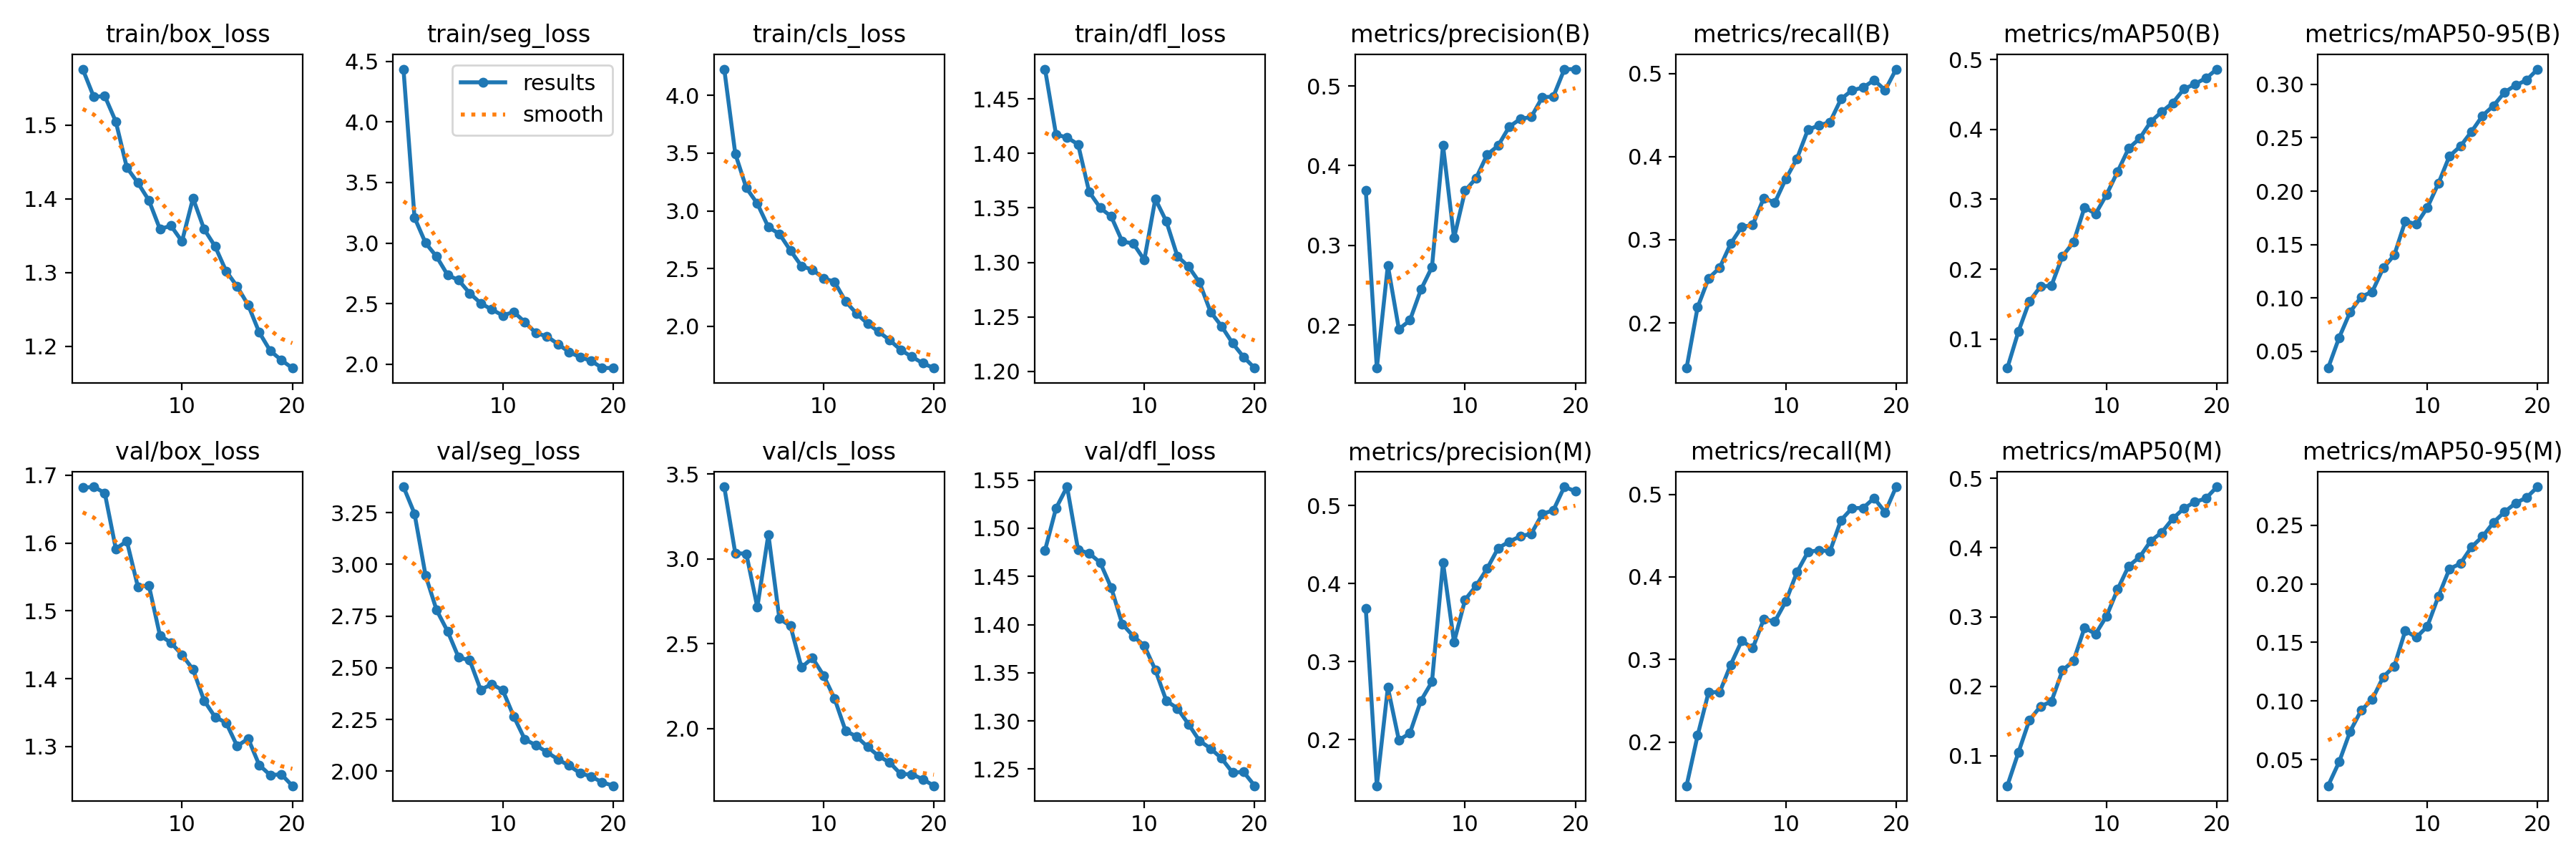

In [5]:
# Plot training results (assuming results have plots)
# For simplicity, display saved plots
from IPython.display import Image
Image('runs/baseline/results.png')
# Similarly for others

## Evaluation

In [6]:
# Evaluation
metrics_baseline = model_baseline.val(data='/kaggle/working/data_labeled.yaml')
metrics_pseudo = model_pseudo.val(data='/kaggle/working/data_combined.yaml')

# Extract Baseline mAP
map50_baseline = metrics_baseline.box.map50
map5095_baseline = metrics_baseline.box.map

# Extract FixMatch/Pseudo-Label model mAP
map50_pseudo = metrics_pseudo.box.map50
map5095_pseudo = metrics_pseudo.box.map

# Print Comparison
print("Evaluation Results:")
print("--------------------")
print("Baseline YOLOv12:")
print(f" - mAP@0.5: {map50_baseline:.4f}")
print(f" - mAP@0.5:0.95: {map5095_baseline:.4f}")

print("\nFixMatch SSL Model:")
print(f" - mAP@0.5: {map50_pseudo:.4f}")
print(f" - mAP@0.5:0.95: {map5095_pseudo:.4f}")

print("\nEvaluation Complete.")


Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2706.7±1754.7 MB/s, size: 334.4 KB)
val: Scanning /kaggle/working/labels/val.cache... 1736 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1736/1736 2.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 109/109 7.0it/s 15.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.519      0.508      0.486      0.315      0.519      0.509      0.488      0.282
        abdominal_wall        215        317      0.444      0.391       0.37       0.28       0.45      0.397      0.383      0.259
                 colon        187        332      0.365      0.428      0.315       0.22      0.364      0.428      0.315      0.198
inferior_mesenteric_artery        150        204      0.517      0.515       0.52      0.278      0.516      0.515      0.509      0.215
      intestinal_veins        143        219      0.588      0.553      0.538      0.306      0.597      0.562      0.547      0.227
                 liver        194        238      0.763      0.769      0.797      0.625      0.773      0.782      0.804      0.586
              pancreas        136        451      0.482      0.384      0.357      0.169      0.476      0.379      0.364      0.146
       small_intestine        156        268      0.417      0.39

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.589      0.602      0.581      0.377      0.593      0.599      0.583      0.339
        abdominal_wall        215        317      0.472      0.445      0.438      0.335      0.478      0.442      0.436      0.299
                 colon        187        332      0.449      0.401      0.347      0.244      0.455      0.401       0.35      0.228
inferior_mesenteric_artery        150        204      0.602      0.662      0.631       0.35      0.608      0.657       0.62      0.285
      intestinal_veins        143        219      0.664      0.598        0.6      0.337      0.665      0.594        0.6      0.256
                 liver        194        238       0.77      0.807      0.803      0.628      0.766      0.798      0.796      0.586
              pancreas        136        451      0.561      0.435      0.438      0.215      0.544      0.419      0.425      0.176
       small_intestine        156        268       0.53      0.50

## Results Table

Results saved to /kaggle/working/runs/pseudo_labels
7631 labels saved to /kaggle/working/runs/pseudo_labels/labels


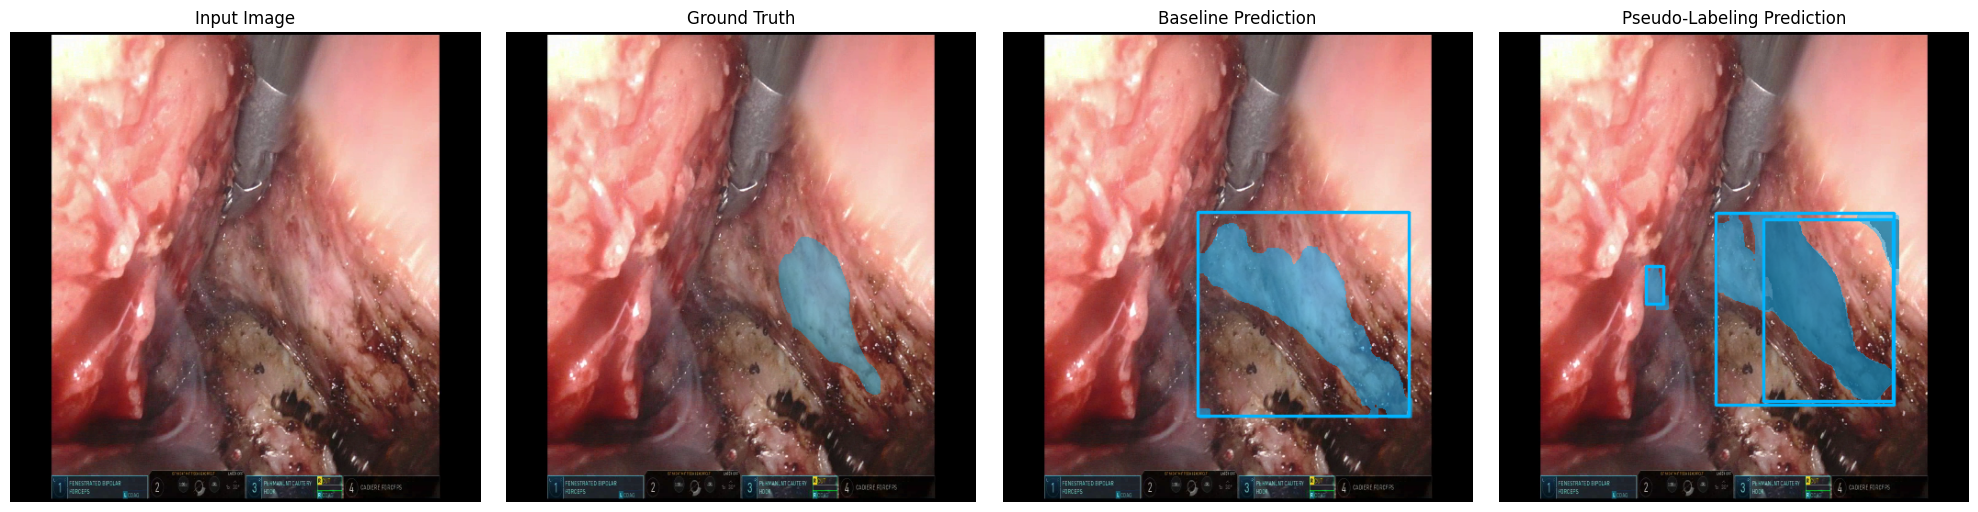

Results saved to /kaggle/working/runs/pseudo_labels
7632 labels saved to /kaggle/working/runs/pseudo_labels/labels


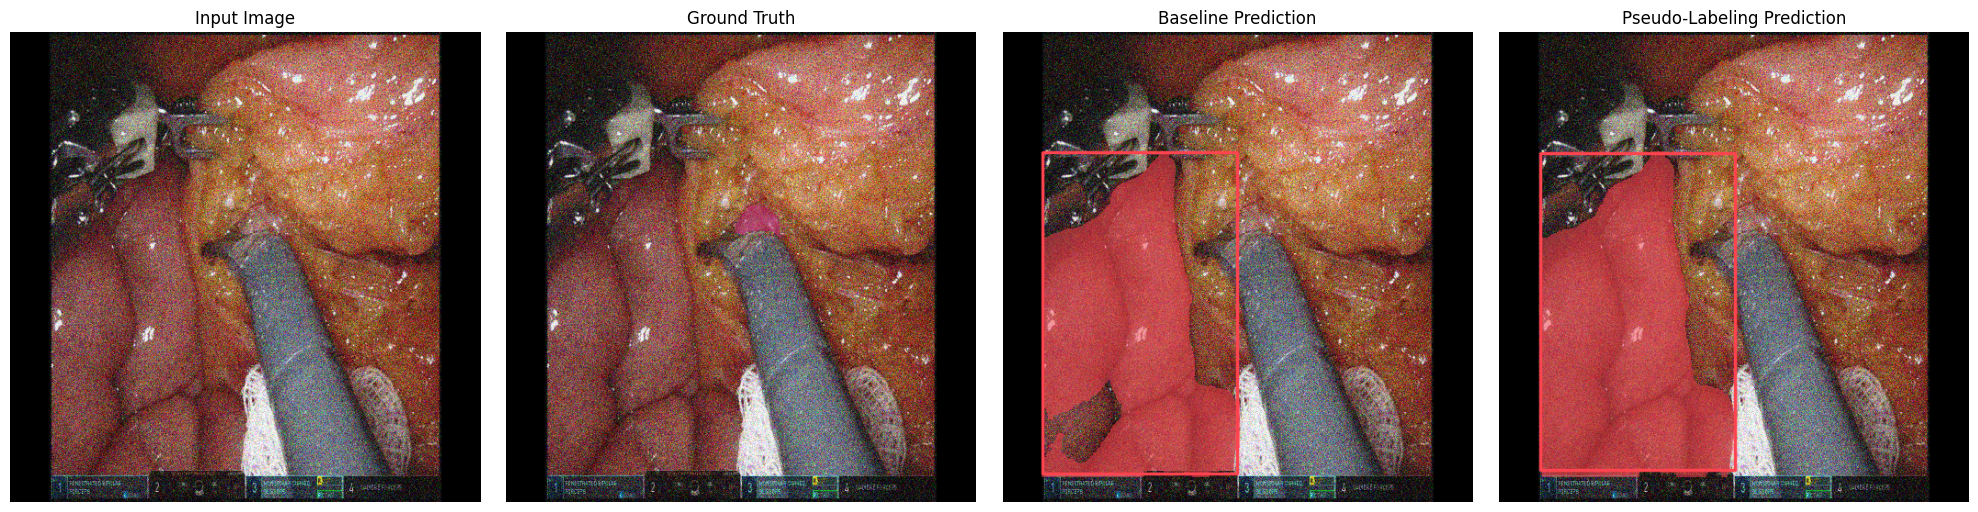

Results saved to /kaggle/working/runs/pseudo_labels
7633 labels saved to /kaggle/working/runs/pseudo_labels/labels


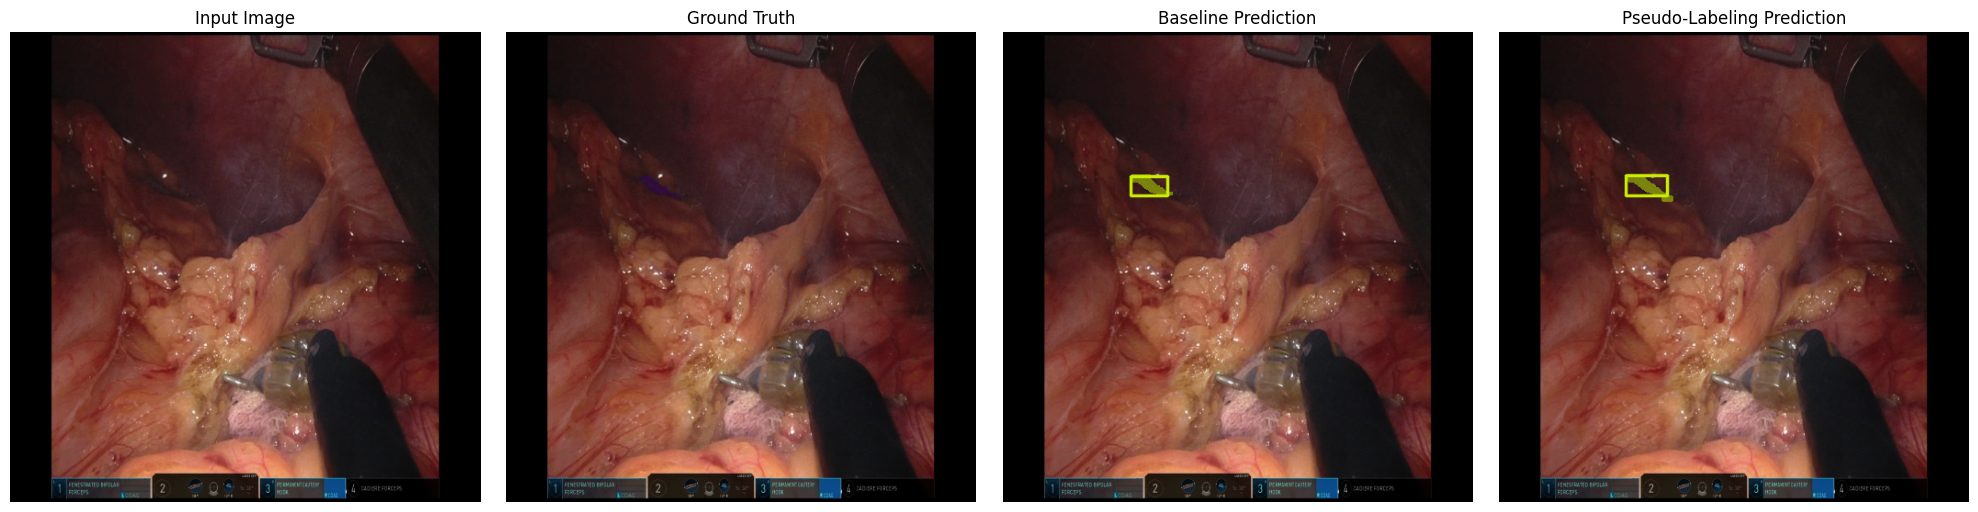

In [7]:
import random
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Helper function to plot ground truth masks on an image
def plot_gt_masks_on_image(image_path, label_dir, class_names, colors=None):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found at {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    label_filename = os.path.basename(image_path).replace('.jpg', '.txt').replace('.png', '.txt')
    full_label_path = os.path.join(label_dir, label_filename)

    overlay = img.copy()
    alpha = 0.5 # Transparency factor for masks

    if os.path.exists(full_label_path):
        with open(full_label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 3: # Ensure there are class_id and at least one coordinate pair
                    continue
                class_id = int(parts[0])
                # Polygons are normalized, need to scale them back
                coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)

                coords[:, 0] *= w
                coords[:, 1] *= h

                # Assign a color based on class_id for consistency, or generate random if not provided
                if colors is None or class_id >= len(colors):
                    color = [random.randint(0, 255) for _ in range(3)]
                else:
                    color = colors[class_id] # Use fixed colors for classes

                # Ensure coords are integers for cv2.fillPoly
                cv2.fillPoly(overlay, [coords.astype(np.int32)], color)

    # Combine the image and the overlay with transparency
    image_with_masks = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    return image_with_masks

# Generate some consistent colors for the classes if data_yaml['names'] is available
class_colors = None
if 'names' in data_yaml:
    num_classes = len(data_yaml['names'])
    np.random.seed(42) # For reproducible colors
    class_colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(num_classes)]

# Visualizations
test_imgs = random.sample(test_images, 3) # Sample 3 images for visualization

for img_name in test_imgs:
    image_path = os.path.join('/kaggle/working/images/test', img_name)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Input Image
    image = Image.open(image_path).convert("RGB")
    axes[0].imshow(image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # 2. Ground Truth Mask
    gt_image_with_masks = plot_gt_masks_on_image(image_path, '/kaggle/working/labels/test', data_yaml['names'], class_colors)
    if gt_image_with_masks is not None:
        axes[1].imshow(gt_image_with_masks)
    else:
        axes[1].imshow(image) # Show original if GT loading fails
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    # 3. Baseline Predictions
    # model_baseline.predict returns a list of Results objects
    results_baseline = model_baseline.predict(image_path, verbose=False) # Set verbose=False to suppress output for each image
    if results_baseline and results_baseline[0].masks is not None:
        # plot() method returns an image with bounding boxes and masks drawn
        # Convert BGR to RGB as plot() returns BGR image
        preds_baseline_img = results_baseline[0].plot(labels=False, conf=False)
        preds_baseline_img = cv2.cvtColor(preds_baseline_img, cv2.COLOR_BGR2RGB)
        axes[2].imshow(preds_baseline_img)
    else:
        axes[2].imshow(image) # Show original image if no detections
    axes[2].set_title('Baseline Prediction')
    axes[2].axis('off')

    # 4. Pseudo-Labeling Predictions
    results_pseudo = model_pseudo.predict(image_path, verbose=False)
    if results_pseudo and results_pseudo[0].masks is not None:
        preds_pseudo_img = results_pseudo[0].plot(labels=False, conf=False)
        preds_pseudo_img = cv2.cvtColor(preds_pseudo_img, cv2.COLOR_BGR2RGB)
        axes[3].imshow(preds_pseudo_img)
    else:
        axes[3].imshow(image) # Show original image if no detections
    axes[3].set_title('Pseudo-Labeling Prediction')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

## Discussion

Semi-supervised learning improves segmentation by leveraging unlabeled data, reducing the need for extensive annotations. Pseudo-labeling was effective but may introduce noise. Mean Teacher provided stable training through EMA. FixMatch excelled with augmentations. Unlabeled data helped in generalization. Challenges include hyperparameter tuning and computational cost.

## Conclusion

This notebook demonstrated SSL for instance segmentation, showing improvements over supervised baseline.